## upsell remodeling
- 기존에는 upsell vs 유지 + downsell
- 새롭게는 upsell vs downsell

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

from sm_utils import make_train_data

from multiprocessing import Pool
from functools import partial
import operator

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data/'

In [3]:
def next_month(ym):
    next_month = datetime.strptime(ym, '%Y%m') + relativedelta(months=1)
    return datetime.strftime(next_month, '%Y%m')

## load data

In [46]:
with open(os.path.join(DATA_PATH, 'new_features.pkl'), 'rb') as f:
    cols = pickle.load(f)

In [47]:
sql_cols = ', '.join(cols)

In [48]:
sql = """
select {COLS}, ym
from dumbo.dominic_new_upsell_train_data
"""

In [70]:
df = load_from_hive(hive_connection('dmig'), sql.format(COLS=sql_cols))

2019-10-30 14:57:55,500 - YE_HIVE - INFO - ...tmp_db name = tmp_20191030_14_57_55_59a36896b3ef51fa0f8a259264b1ff59308f8f07
2019-10-30 14:57:55,502 - YE_HIVE - INFO - Start creating table
2019-10-30 14:57:55,503 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20191030_14_57_55_59a36896b3ef51fa0f8a259264b1ff59308f8f07
2019-10-30 14:57:55,559 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20191030_14_57_55_59a36896b3ef51fa0f8a259264b1ff59308f8f07' is done
2019-10-30 15:00:39,539 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20191030_14_57_55_59a36896b3ef51fa0f8a259264b1ff59308f8f07 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
select svc_mgmt_num, fee_prod_id, prod_nm, bas_fee_amt, fee_chg_period, age, bas_ofr_data_gb_qty_val, bf_m6_data_usage_ratio_avg, voc_srv_cnt, real_data_use_gb_b

In [71]:
df.shape

(1833173, 110)

## preprocess

#### null check

In [72]:
# null check
col_null_sum = df.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  Series([], dtype: int64)


#### del eqp_chg rows

In [73]:
df = df[df['label_eqp_chg_yn']=='N']

#### label encoding

In [74]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

cat_cols = list(df.select_dtypes(include=['object']).columns)

In [75]:
cat_cols

['svc_mgmt_num',
 'fee_prod_id',
 'prod_nm',
 't_agr_t_eqpal_scrb_ym',
 'eqp_mdl_cd',
 'mng_nice_cb_scr',
 'svc_gr_cd',
 'channel',
 'family_yn',
 'op_sale_chnl_cl_cd',
 'sex_cd',
 'label_bf_prod_id',
 'label_af_prod_id',
 'label_upsell',
 'label_eqp_chg_yn',
 'label_af_channel',
 'ym']

In [76]:
cat_cols = ['t_agr_t_eqpal_scrb_ym', 'eqp_mdl_cd', 'mng_nice_cb_scr', 'svc_gr_cd', 'channel', 
            'family_yn', 'op_sale_chnl_cl_cd', 'sex_cd', 'label_upsell']

In [77]:
# label encodinng
d = defaultdict(LabelEncoder)
df[cat_cols] = df[cat_cols].apply(lambda x: d[x.name].fit_transform(x))

d.keys()

dict_keys(['t_agr_t_eqpal_scrb_ym', 'eqp_mdl_cd', 'mng_nice_cb_scr', 'svc_gr_cd', 'channel', 'family_yn', 'op_sale_chnl_cl_cd', 'sex_cd', 'label_upsell'])

In [78]:
## save label encoder
with open(os.path.join(DATA_PATH, 'new_upsell_le_dict.pkl'), 'wb') as f:
    pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)

In [79]:
df.to_pickle(os.path.join(DATA_PATH, 'new_upsell_1030.pkl'))

## modeling

In [80]:
def lgb_train(params, train_set, valid_sets):
    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=2000,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    print('elapsed time:', time.time()-t1)
    return clf

In [81]:
df_trn = df[df['ym']=='201906']
df_val = df[df['ym']=='201907']
df_tst = df[df['ym']=='201908']

df_trn.shape, df_val.shape, df_tst.shape

((377002, 110), (374642, 110), (321682, 110))

In [82]:
del df
import gc
gc.collect()

6067

In [83]:
label_cols = [c for c in df_trn.columns if 'label_' in c]
del_cols = ['svc_mgmt_num', 'ym', 'fee_prod_id', 'prod_nm']
del_cols += label_cols
feature_cols = [c for c in df_trn.columns if c not in del_cols]

In [84]:
target = 'label_upsell'

In [85]:
# best parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_threads': 50,
}

In [86]:
from sm_utils import sampling, evaluate, save_model, load_model

channel:  고객센터
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.919638	valid_1's auc: 0.91607
[100]	training's auc: 0.92942	valid_1's auc: 0.924304
[150]	training's auc: 0.934591	valid_1's auc: 0.927635
[200]	training's auc: 0.938521	valid_1's auc: 0.928999
[250]	training's auc: 0.941807	valid_1's auc: 0.929526
[300]	training's auc: 0.944692	valid_1's auc: 0.929894
[350]	training's auc: 0.947157	valid_1's auc: 0.930218
[400]	training's auc: 0.949438	valid_1's auc: 0.930328
[450]	training's auc: 0.951677	valid_1's auc: 0.930546
[500]	training's auc: 0.953752	valid_1's auc: 0.930712
[550]	training's auc: 0.955692	valid_1's auc: 0.930692
[600]	training's auc: 0.957486	valid_1's auc: 0.930724
[650]	training's auc: 0.959236	valid_1's auc: 0.930819
[700]	training's auc: 0.960912	valid_1's auc: 0.930841
[750]	training's auc: 0.962521	valid_1's auc: 0.930847
[800]	training's auc: 0.964125	valid_1's auc: 0.930878
[850]	training's auc: 0.965559	valid_1's auc:

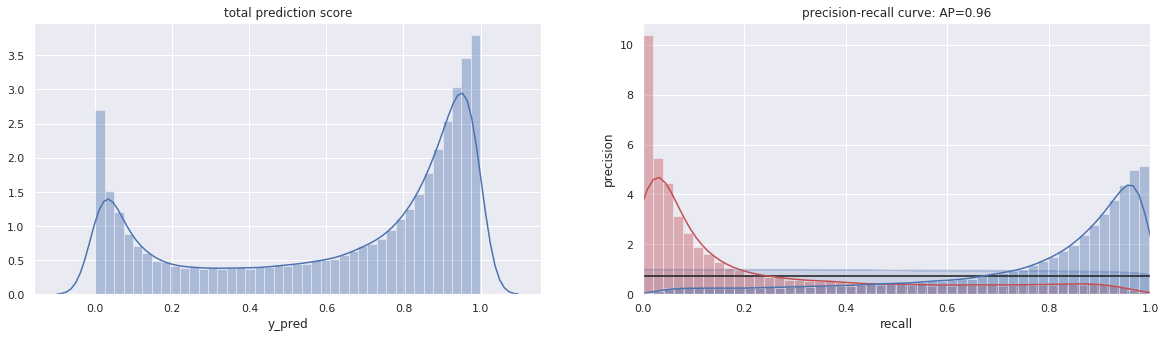

channel:  T월드
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.880674	valid_1's auc: 0.885572
[100]	training's auc: 0.895082	valid_1's auc: 0.895722
[150]	training's auc: 0.902893	valid_1's auc: 0.900009
[200]	training's auc: 0.908503	valid_1's auc: 0.902278
[250]	training's auc: 0.913186	valid_1's auc: 0.903471
[300]	training's auc: 0.917207	valid_1's auc: 0.904133
[350]	training's auc: 0.920937	valid_1's auc: 0.904658
[400]	training's auc: 0.924482	valid_1's auc: 0.904859
[450]	training's auc: 0.927848	valid_1's auc: 0.905136
[500]	training's auc: 0.930895	valid_1's auc: 0.905272
[550]	training's auc: 0.933893	valid_1's auc: 0.905418
[600]	training's auc: 0.936746	valid_1's auc: 0.905569
[650]	training's auc: 0.939452	valid_1's auc: 0.905602
[700]	training's auc: 0.941946	valid_1's auc: 0.905681
[750]	training's auc: 0.944443	valid_1's auc: 0.905711
[800]	training's auc: 0.946856	valid_1's auc: 0.905734
[850]	training's auc: 0.949153	valid_1's auc

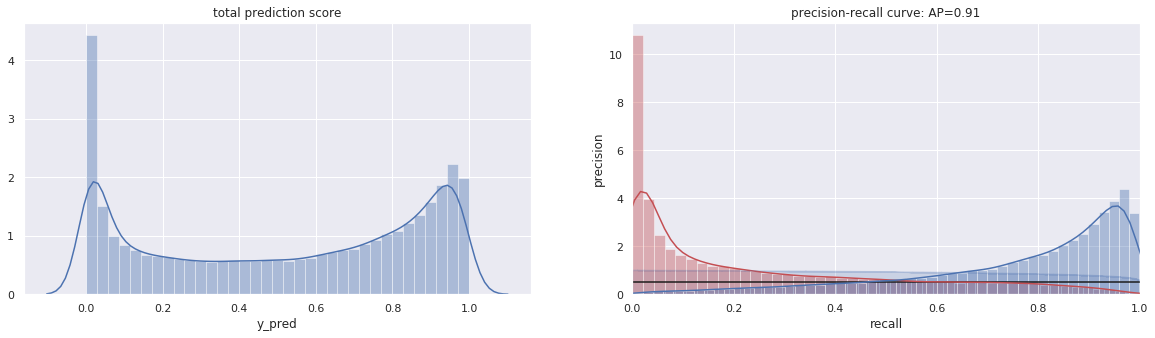

channel:  오프라인
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.935734	valid_1's auc: 0.923009
[100]	training's auc: 0.945391	valid_1's auc: 0.93101
[150]	training's auc: 0.951048	valid_1's auc: 0.934317
[200]	training's auc: 0.955176	valid_1's auc: 0.935394
[250]	training's auc: 0.958696	valid_1's auc: 0.935908
[300]	training's auc: 0.961922	valid_1's auc: 0.936253
[350]	training's auc: 0.964865	valid_1's auc: 0.936475
[400]	training's auc: 0.967497	valid_1's auc: 0.936583
[450]	training's auc: 0.970002	valid_1's auc: 0.936698
[500]	training's auc: 0.972344	valid_1's auc: 0.936892
[550]	training's auc: 0.974459	valid_1's auc: 0.936924
[600]	training's auc: 0.97643	valid_1's auc: 0.93696
[650]	training's auc: 0.97817	valid_1's auc: 0.936948
Early stopping, best iteration is:
[593]	training's auc: 0.976189	valid_1's auc: 0.936977
elapsed time: 59.149916648864746
        acc    recall  precision  f1_score       auc
0  0.855359  0.877123   0.717408  0.

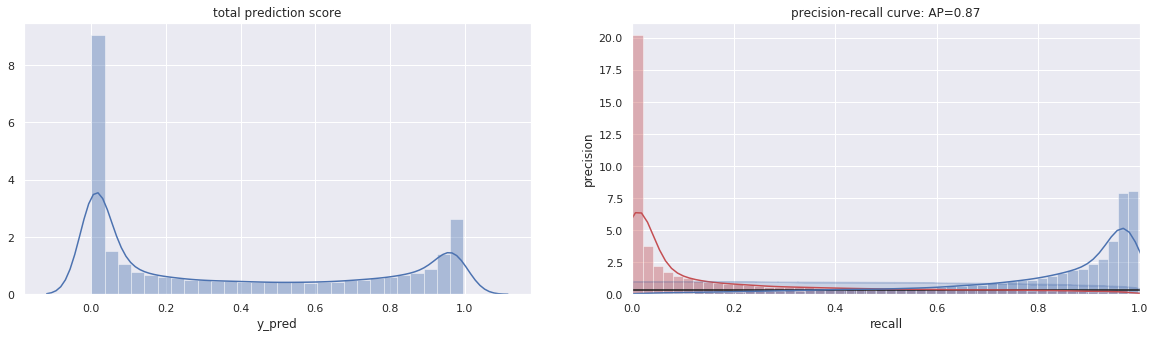

In [109]:
clf_dict = {}
for c in ['고객센터', 'T월드', '오프라인']:
    print('='*50)
    print('channel: ', c)
    
    df_trn_tmp = df_trn[df_trn['label_af_channel']==c]
    df_val_tmp = df_val[df_val['label_af_channel']==c]
    df_tst_tmp = df_tst[df_tst['label_af_channel']==c]
    
    # train
    lgb_trn = lgb.Dataset(df_trn_tmp[feature_cols], df_trn_tmp[target], feature_name=feature_cols)
    lgb_val = lgb.Dataset(df_val_tmp[feature_cols], df_val_tmp[target], feature_name=feature_cols)
    clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])
    
    # evaluate
    eval_result = evaluate(df_tst_tmp[feature_cols], df_tst_tmp[target].values, clf, clf_name='lgb')
    
    # save
    clf_dict[c] = clf

## 전체고객

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.905429	valid_1's auc: 0.90736
[100]	training's auc: 0.915917	valid_1's auc: 0.916491
[150]	training's auc: 0.921159	valid_1's auc: 0.920817
[200]	training's auc: 0.924537	valid_1's auc: 0.923301
[250]	training's auc: 0.926899	valid_1's auc: 0.924743
[300]	training's auc: 0.928778	valid_1's auc: 0.92559
[350]	training's auc: 0.930366	valid_1's auc: 0.926153
[400]	training's auc: 0.931743	valid_1's auc: 0.926537
[450]	training's auc: 0.933044	valid_1's auc: 0.926868
[500]	training's auc: 0.934246	valid_1's auc: 0.927073
[550]	training's auc: 0.935387	valid_1's auc: 0.927203
[600]	training's auc: 0.936469	valid_1's auc: 0.92737
[650]	training's auc: 0.937535	valid_1's auc: 0.927526
[700]	training's auc: 0.938559	valid_1's auc: 0.927678
[750]	training's auc: 0.939528	valid_1's auc: 0.927721
[800]	training's auc: 0.940516	valid_1's auc: 0.927788
[850]	training's auc: 0.941434	valid_1's auc: 0.9279
[900]	tr

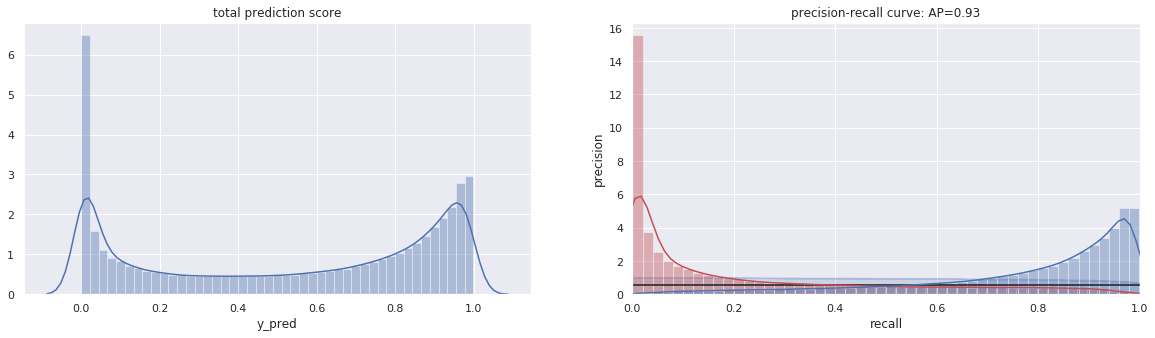

In [110]:
# train
lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[target], feature_name=feature_cols)
lgb_val = lgb.Dataset(df_val[feature_cols], df_val[target], feature_name=feature_cols)
clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])

# evaluate
eval_result = evaluate(df_tst[feature_cols], df_tst[target].values, clf, clf_name='lgb')

# save
clf_dict['total'] = clf

In [112]:
clf_dict

{'고객센터': <lightgbm.basic.Booster at 0x7f57ad3bbe80>,
 'T월드': <lightgbm.basic.Booster at 0x7f57ae9750f0>,
 '오프라인': <lightgbm.basic.Booster at 0x7f57a715b278>,
 'total': <lightgbm.basic.Booster at 0x7f57973c78d0>}

In [99]:
tmp_dict = {'고객센터': 'center', 'T월드':'tworld', '오프라인':'offline', 'total': 'total'}

In [113]:
DATA_PATH

'/home/dmig/work/upsell/data/'

In [ ]:
    with open(path, 'wb') as f:
        pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [115]:
for c, clf in clf_dict.items():
    print('c: ', c)
    with open(os.path.join(DATA_PATH, '{}_upsell.pkl'.format(tmp_dict[c])), 'wb') as f:
        pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)

c:  고객센터
c:  T월드
c:  오프라인
c:  total


## test

In [ ]:
tmp_sql2 = """
table dumbo.dominic_user_label_matrix_for_fee_no_equip_temp;

create TABLE dumbo.dominic_user_label_matrix_for_fee_no_equip_temp as
SELECT      a.svc_mgmt_num
,           b.fee_prod_id as bf_prod_id
,           a.fee_prod_id as af_prod_id
,           if(CAST(a.bas_fee_amt AS INT) > CAST(b.bas_fee_amt AS INT),'Y','N') as upsell
,           CAST(a.bas_fee_amt AS INT) - CAST(b.bas_fee_amt AS INT) as diff
,           IF(c.svc_mgmt_num IS NULL, 'N','Y') AS eqp_chg_yn 
,           a.channel as af_channel
,           CAST(b.age AS INT) as age
,           '201909' as ym
FROM
(
    SELECT	svc_mgmt_num
    ,       channel
    ,       CASE
                WHEN fee_prod_id = 'NA00005955' THEN 'NA00006534'
                WHEN fee_prod_id = 'NA00006324' THEN 'NA00006535'
                WHEN fee_prod_id = 'NA00005956' THEN 'NA00006536'
                WHEN fee_prod_id = 'NA00005957' THEN 'NA00006537'
                WHEN fee_prod_id = 'NA00005958' THEN 'NA00006538'
                WHEN fee_prod_id = 'NA00005959' THEN 'NA00006539'
            ELSE fee_prod_id END AS fee_prod_id
    ,		bas_fee_amt
    FROM
        comm.user_profile_pivot_monthly
    WHERE   ym = '201909'
) a
JOIN 
(
    SELECT	svc_mgmt_num
    ,       CASE
                WHEN fee_prod_id = 'NA00005955' THEN 'NA00006534'
                WHEN fee_prod_id = 'NA00006324' THEN 'NA00006535'
                WHEN fee_prod_id = 'NA00005956' THEN 'NA00006536'
                WHEN fee_prod_id = 'NA00005957' THEN 'NA00006537'
                WHEN fee_prod_id = 'NA00005958' THEN 'NA00006538'
                WHEN fee_prod_id = 'NA00005959' THEN 'NA00006539'
            ELSE fee_prod_id END AS fee_prod_id
    ,		bas_fee_amt
    ,       age
    FROM
        comm.user_profile_pivot_monthly
    WHERE   ym = '201908'
) b
ON      a.svc_mgmt_num = b.svc_mgmt_num
LEFT JOIN
(
    SELECT  distinct svc_mgmt_num
    FROM    comm.change_fee_history
    WHERE   substr(scrb_dt, 1, 6) = '201909'
    AND     eqp_chg_yn = 'Y'
) c
ON      a.svc_mgmt_num = c.svc_mgmt_num
; 


"""

In [4]:
tmp_sql = """
drop table dumbo.dominic_new_upsell_train_data;
create table dumbo.dominic_new_upsell_test_data as 
select 
    b.*
,   a.bf_prod_id as label_bf_prod_id
,   a.af_prod_id as label_af_prod_id
,   a.upsell as label_upsell
,   a.diff as label_diff
,   a.eqp_chg_yn as label_eqp_chg_yn
,   a.af_channel as label_af_channel
,   a.ym as a_ym
,   b.ym as b_ym
from dumbo.dominic_user_label_matrix_for_fee_no_equip_temp a
join comm.user_profile_pivot_monthly b
on a.svc_mgmt_num = b.svc_mgmt_num 
and b.ym = date_format(add_months(from_unixtime(unix_timestamp(a.ym,'yyyyMM'),'yyyy-MM-dd'),-1), 'yyyyMM')
where a.age between 19 and 70 
;
"""

In [5]:
with open(os.path.join(DATA_PATH, 'new_features.pkl'), 'rb') as f:
    cols = pickle.load(f)

In [6]:
sql_cols = ', '.join(cols)

In [7]:
sql = """
select {COLS}, ym
from dumbo.dominic_new_upsell_test_data
"""

In [8]:
df = load_from_hive(hive_connection('dmig'), sql.format(COLS=sql_cols))

2019-10-31 23:35:56,903 - YE_HIVE - INFO - ...tmp_db name = tmp_20191031_23_35_56_f6ba4603b544226e552c70b27f5da27d634bb13d
2019-10-31 23:35:56,906 - YE_HIVE - INFO - Start creating table
2019-10-31 23:35:56,907 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20191031_23_35_56_f6ba4603b544226e552c70b27f5da27d634bb13d
2019-10-31 23:35:56,964 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20191031_23_35_56_f6ba4603b544226e552c70b27f5da27d634bb13d' is done
2019-10-31 23:38:49,780 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20191031_23_35_56_f6ba4603b544226e552c70b27f5da27d634bb13d 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
select svc_mgmt_num, fee_prod_id, prod_nm, bas_fee_amt, fee_chg_period, age, bas_ofr_data_gb_qty_val, bf_m6_data_usage_ratio_avg, voc_srv_cnt, real_data_use_gb_b

In [9]:
df.shape

(15468277, 110)

In [10]:
# null check
col_null_sum = df.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  Series([], dtype: int64)


In [11]:
## load label encoder
with open(os.path.join(DATA_PATH, 'new_upsell_le_dict.pkl'), 'rb') as f:
    le_dict = pickle.load(f)

In [12]:
error_cols = []
for col in le_dict.keys():
    print('col: ', col)
        
    try:
        df[col] = le_dict[col].transform(df[col])
    except:
        error_cols.append(col)

col:  t_agr_t_eqpal_scrb_ym
col:  eqp_mdl_cd
col:  mng_nice_cb_scr
col:  svc_gr_cd
col:  channel
col:  family_yn
col:  op_sale_chnl_cl_cd
col:  sex_cd
col:  label_upsell


In [13]:
error_cols

['eqp_mdl_cd', 'mng_nice_cb_scr', 'op_sale_chnl_cl_cd']

In [14]:
for col in error_cols:
    tmp_dict = dict(zip(le_dict[col].classes_, le_dict[col].transform(le_dict[col].classes_)))
    df[col] = df[col].apply(lambda x: tmp_dict.get(x, -9999))

## load model

In [16]:
tmp_dict = {'고객센터': 'center', 'T월드':'tworld', '오프라인':'offline', 'total': 'total'}

In [17]:
load_clf_dict = {}

for c in tmp_dict.keys():
    print('c: ', c)
    with open(os.path.join(DATA_PATH, '{}_upsell.pkl'.format(tmp_dict[c])), 'rb') as f:
        load_clf_dict[c] = pickle.load(f)

c:  고객센터
c:  T월드
c:  오프라인
c:  total


In [18]:
load_clf_dict

{'고객센터': <lightgbm.basic.Booster at 0x7fe49e178908>,
 'T월드': <lightgbm.basic.Booster at 0x7fe49e178400>,
 '오프라인': <lightgbm.basic.Booster at 0x7fe49e178860>,
 'total': <lightgbm.basic.Booster at 0x7fe49e1788d0>}

In [21]:
label_cols = [c for c in df.columns if 'label_' in c]
del_cols = ['svc_mgmt_num', 'ym', 'fee_prod_id', 'prod_nm']
del_cols += label_cols
feature_cols = [c for c in df.columns if c not in del_cols]

In [22]:
len(feature_cols)

100

In [23]:
df['pred'] = load_clf_dict['total'].predict(df[feature_cols], num_threads=40)

In [24]:
df.head()

svc_mgmt_num fee_prod_id        prod_nm  bas_fee_amt  fee_chg_period   age  \
0   1000011002  NA00006403        5GX스탠다드      75000.0            94.0  43.0   
1   1000028502  NA00004773  band 데이터 6.5G      56100.0          1306.0  60.0   
2   1000050715  NA00005955             스몰      33000.0           205.0  63.0   
3   1000088111  NA00004775   band 데이터 퍼펙트      65890.0           865.0  45.0   
4   1000210003  NA00005959      Data 인피니티     100000.0           362.0  38.0   

   bas_ofr_data_gb_qty_val  bf_m6_data_usage_ratio_avg  voc_srv_cnt  \
0                    200.0                    0.155366         15.0   
1                      6.5                    0.179170         14.0   
2                      1.2                    0.399273         13.0   
3                     11.0                    0.450686         14.0   
4                      0.0                    0.000000         17.0   

   real_data_use_gb_bf_m0  ...  avg_eqp_buy_duration  last_eqp_buy_duration  \
0               25.454430  ...             54.000000                   55.0   
1                1.927886  ...             54.000000                   48.0   
2                0.501202  ...            178.000000                   11.0   
3                4.813911  ...            113.666667                    1.0   
4               52.206724  ...            187.500000                  284.0   

   label_bf_prod_id  label_af_prod_id  label_upsell  label_diff  \
0        NA00006403        NA00006403             0           0   
1        NA00004773        NA00004773             0           0   
2        NA00006534        NA00006534             0           0   
3        NA00004775        NA00004775             0           0   
4        NA00006539        NA00006539             0           0   

   label_eqp_chg_yn  label_af_channel      ym      pred  
0                 N              오프라인  201908  0.944016  
1                 N              고객센터  201908  0.060040  
2                 N              고객센터  201908  0.829486  
3                 N              오프라인  201908  0.225955  
4                 N              오프라인  201908  0.002368  

[5 rows x 111 columns]

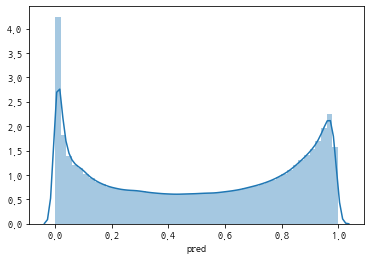

In [25]:
sns.distplot(df.pred)

In [30]:
df_tmp = df[['svc_mgmt_num', 'prod_nm', 'bas_fee_amt', 
             'pred']].sort_values('pred', ascending=False).head(6000000)

In [31]:
df_tmp.head()

svc_mgmt_num      prod_nm  bas_fee_amt      pred
42336   7253836810           슬림      55000.0  0.999503
26499   7228415229  T끼리맞춤형45~54          0.0  0.999445
47167   7260813637        표준요금제      12100.0  0.999438
26634   7229050629           슬림      55000.0  0.999427
18170   7189590964      T플랜 세이브      33000.0  0.999367

In [36]:
df_tmp.bas_fee_amt.value_counts().head(20)/df_tmp.shape[0]

33000.0    0.282198
65890.0    0.160114
32890.0    0.112887
0.0        0.057536
12100.0    0.049965
39600.0    0.038393
43000.0    0.036620
50000.0    0.032782
56100.0    0.023146
69000.0    0.021233
75900.0    0.019745
16500.0    0.019330
75000.0    0.018628
19800.0    0.015992
30690.0    0.012069
46200.0    0.012016
43175.0    0.011553
9900.0     0.010117
55000.0    0.009827
39930.0    0.009209
Name: bas_fee_amt, dtype: float64

In [37]:
df_tmp.prod_nm.value_counts().head(20)/df_tmp.shape[0]

스몰                     0.211293
band 데이터 퍼펙트           0.160067
band 데이터 세이브           0.112193
표준요금제                  0.049690
T플랜 세이브                0.042780
band 데이터 1.2G          0.038373
LTE 맞춤형 24~33          0.030778
band 데이터 6.5G          0.023142
미디엄                    0.022160
band 데이터 퍼펙트S          0.019733
0플랜 스몰                 0.018943
5GX스탠다드                0.018628
레귤러                    0.018358
T플랜 안심2.5G             0.018262
라지                     0.017299
T끼리 어르신                0.015859
T 포켓파이 10              0.014115
band 어르신 세이브           0.012060
band 데이터 2.2G          0.011995
뉴 T끼리 맞춤형(100분+6GB)    0.011541
Name: prod_nm, dtype: float64

In [38]:
df_old = load_from_hive(hive_connection('dmig'), 'select * from dumbo.dominic_upsell_test_dist2')

2019-10-31 23:56:41,966 - YE_HIVE - INFO - ...tmp_db name = tmp_20191031_23_56_41_8878646ce27cc0444c3c313df2f7d798ee834de3
2019-10-31 23:56:41,968 - YE_HIVE - INFO - Start creating table
2019-10-31 23:56:41,968 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20191031_23_56_41_8878646ce27cc0444c3c313df2f7d798ee834de3
2019-10-31 23:56:42,022 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20191031_23_56_41_8878646ce27cc0444c3c313df2f7d798ee834de3' is done
2019-10-31 23:59:28,767 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20191031_23_56_41_8878646ce27cc0444c3c313df2f7d798ee834de3 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from dumbo.dominic_upsell_test_dist2' is done
2019-10-31 23:59:29,005 - YE_HIVE - INFO - Elapsed Time = 167.04
2019-10-31 23:59:29,006 - YE_HIVE - INFO -

In [39]:
df_old.shape

(5999999, 5)

In [43]:
df_tmp.shape

(6000000, 4)

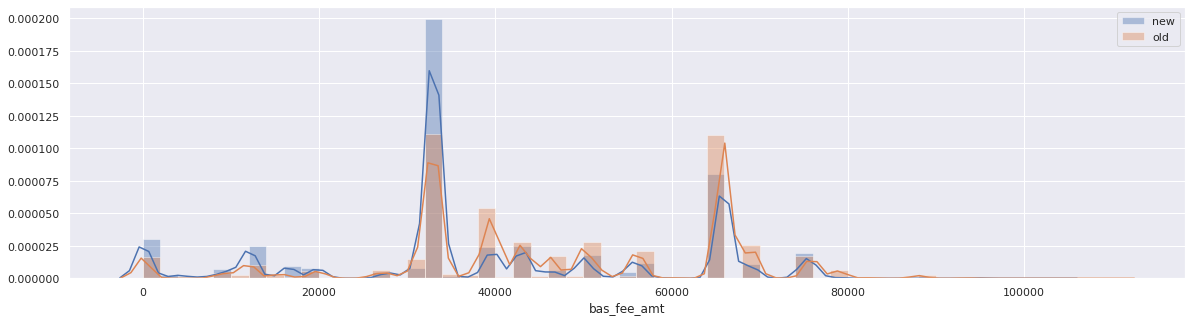

In [45]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df_tmp.bas_fee_amt, norm_hist=True, label='new', bins=np.arange(0, 100000, 2000))
sns.distplot(df_old.bas_fee_amt, norm_hist=True, label='old', bins=np.arange(0, 100000, 2000))
plt.legend()

In [46]:
df_old.head()

svc_mgmt_num   score       rn       prod_nm  bas_fee_amt
0   7307191197  0.4710  5998876    T플랜 안심2.5G      43000.0
1   7259733448  0.4710  5998494           미디엄      50000.0
2   7271361911  0.4711  5995497            스몰      33000.0
3   7244499421  0.4711  5995394  band 데이터 퍼펙트      65890.0
4   7250541893  0.4712  5994493  band 데이터 퍼펙트      65890.0

In [50]:
df_old.bas_fee_amt.mean()

46127.56759292793

In [51]:
df_tmp.bas_fee_amt.mean()

38914.88445333333

In [ ]:
100 call 